(mmm_media_saturation)=
# Understanding Media Saturation in Marketing Mix Models

One of the most important concepts in Marketing Mix Modeling (MMM) is **media saturation** - the phenomenon where the incremental impact of advertising spend diminishes as spending increases. Understanding saturation is crucial for making optimal budget allocation decisions.

This tutorial explores two complementary ways to visualize and understand media saturation after fitting an MMM.

1. **Direct/Marginal Contribution** (`saturation_scatterplot`) - Shows the relationship between spend and contribution at each time point.

2. **Total Contribution over Spend Share** (`plot_channel_contribution_grid`) - Shows how total contribution changes as you scale overall spend

```{warning}
These two visualizations answer different questions and are often confused. This tutorial clarifies the distinction and provides guidance on when to use each.
```

## Setup and Data Preparation

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import preliz as pz
import seaborn as sns
from pymc_extras.prior import Prior

from pymc_marketing.mmm import GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.multidimensional import MMM
from pymc_marketing.paths import data_dir

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Understanding the Saturation Curve

Before diving into the visualizations, let's understand what a saturation curve represents. In this notebook we consider the **logistic saturation function**:

$$
f(x) = \beta \cdot \frac{1 - e^{-\lambda x}}{1 + e^{-\lambda x}}
$$



Where:
- $x$ is the (adstocked) media spend
- $\beta$ is the **saturation ceiling** - the maximum contribution a channel can achieve
- $\lambda$ is the **efficiency parameter** - how quickly the curve approaches saturation



PyMC-Marketing provides the {class}`~pymc_marketing.mmm.components.saturation.LogisticSaturation` class to work with this transformation. This class allows us to:
- Define custom priors for the parameters
- Sample from the prior distributions
- Visualize the saturation curves

Let's explore how to use this class and understand how the parameters affect the saturation curve.

In [3]:
# Create a LogisticSaturation instance with default priors
saturation = LogisticSaturation()

# View the default priors for the saturation parameters
saturation.default_priors

{'lam': Prior("Gamma", alpha=3, beta=1), 'beta': Prior("HalfNormal", sigma=2)}

```{note}
PyMC-Marketing provides many other saturation functions like {class}`~pymc_marketing.mmm.components.saturation.HillSaturation` and {class}`~pymc_marketing.mmm.components.saturation.MichaelisMentenSaturation`.
```

Before doing any sampling, let's get an intuition of how the parameters affect the saturation curve.

/var/folders/cm/3dzy9rdd5s3672z0s1brjkvh0000gn/T/ipykernel_27633/1421674359.py:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


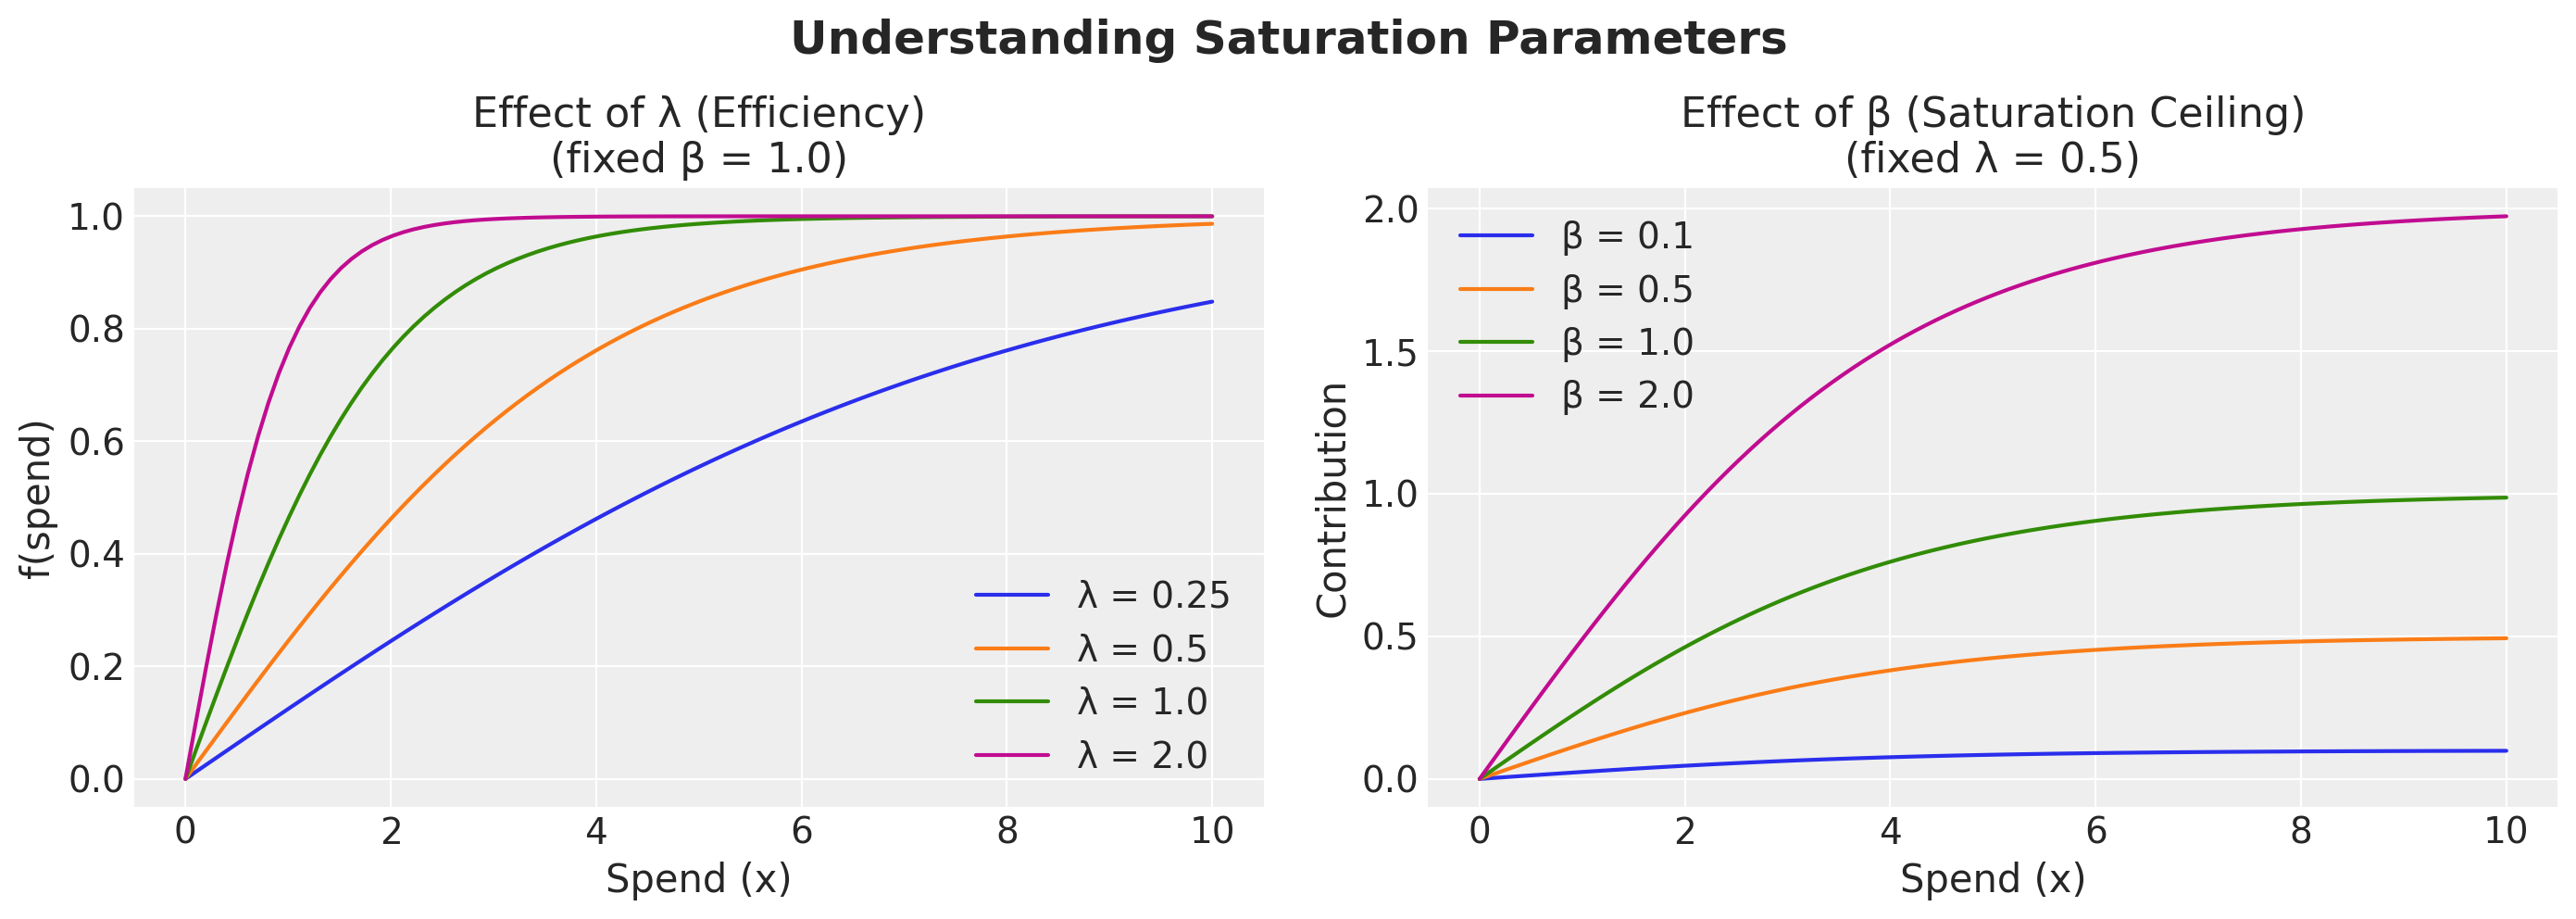

In [4]:
x = np.linspace(0, 10, 100)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Effect of lambda (efficiency) - using the transformer function
ax = axes[0]
for lam in [0.25, 0.5, 1.0, 2.0]:
    y = saturation.function(x, lam=lam, beta=1.0).eval()
    ax.plot(x, y, label=f"λ = {lam}")

ax.legend()
ax.set(
    title="Effect of λ (Efficiency)\n(fixed β = 1.0)",
    xlabel="Spend (x)",
    ylabel="f(spend)",
)

# Effect of beta (saturation ceiling) - using the class function
ax = axes[1]
for beta in [0.1, 0.5, 1.0, 2.0]:
    y = saturation.function(x, lam=0.5, beta=beta).eval()
    ax.plot(x, y, label=f"β = {beta}")

ax.set(
    title="Effect of β (Saturation Ceiling)\n(fixed λ = 0.5)",
    xlabel="Spend (x)",
    ylabel="Contribution",
)
ax.legend()

fig.suptitle("Understanding Saturation Parameters", fontsize=18, fontweight="bold")
plt.tight_layout()

**Key observations:**
- Higher $\beta$ → Higher maximum contribution (the curve's ceiling)
- Higher $\lambda$ → Faster saturation (the curve rises more steeply but plateaus sooner)



Next, we show how to sample from the prior distributions and visualize the saturation curves.

Sampling: [saturation_beta, saturation_lam]
Sampling: []


Output()

/var/folders/cm/3dzy9rdd5s3672z0s1brjkvh0000gn/T/ipykernel_27633/1141326037.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


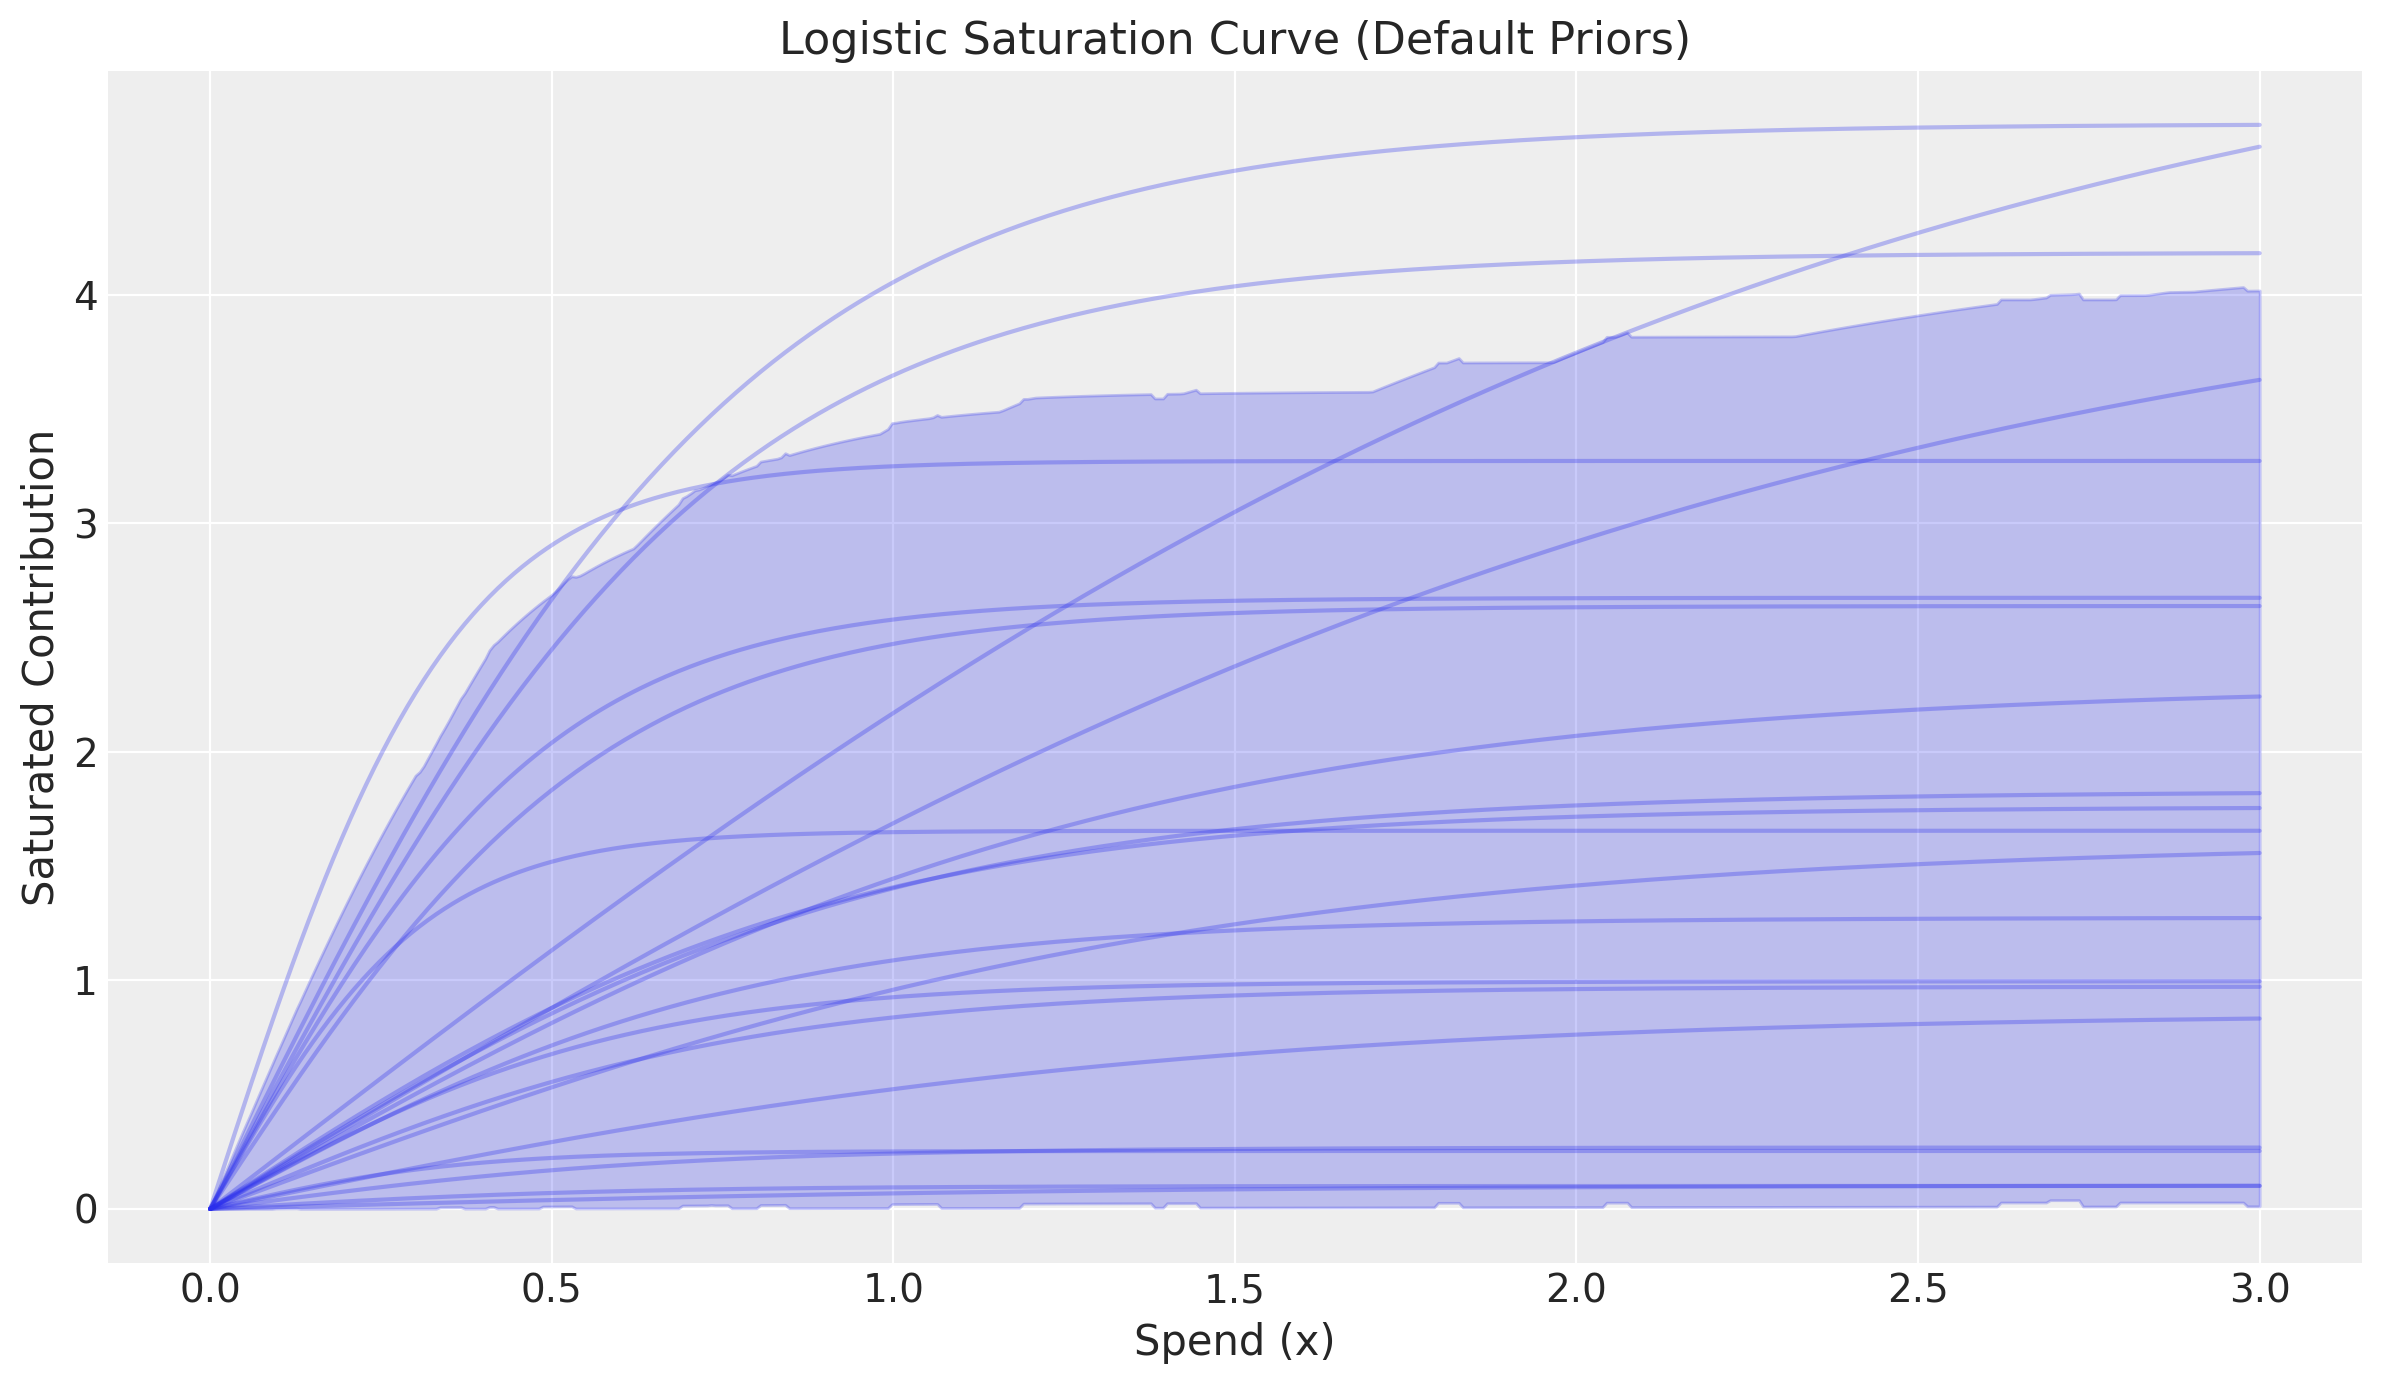

In [5]:
# Sample from the prior distributions
prior = saturation.sample_prior(random_seed=rng)

# Sample the saturation curve across a range of spend values
curve = saturation.sample_curve(prior, num_points=500, max_value=3)

# Plot the saturation curve with uncertainty (HDI and samples)
fig, axes = saturation.plot_curve(curve, n_samples=20, random_seed=rng)
axes[0].set(
    xlabel="Spend (x)",
    ylabel="Saturated Contribution",
    title="Logistic Saturation Curve (Default Priors)",
)
plt.tight_layout()

Let's do the same thing with more tight priors.

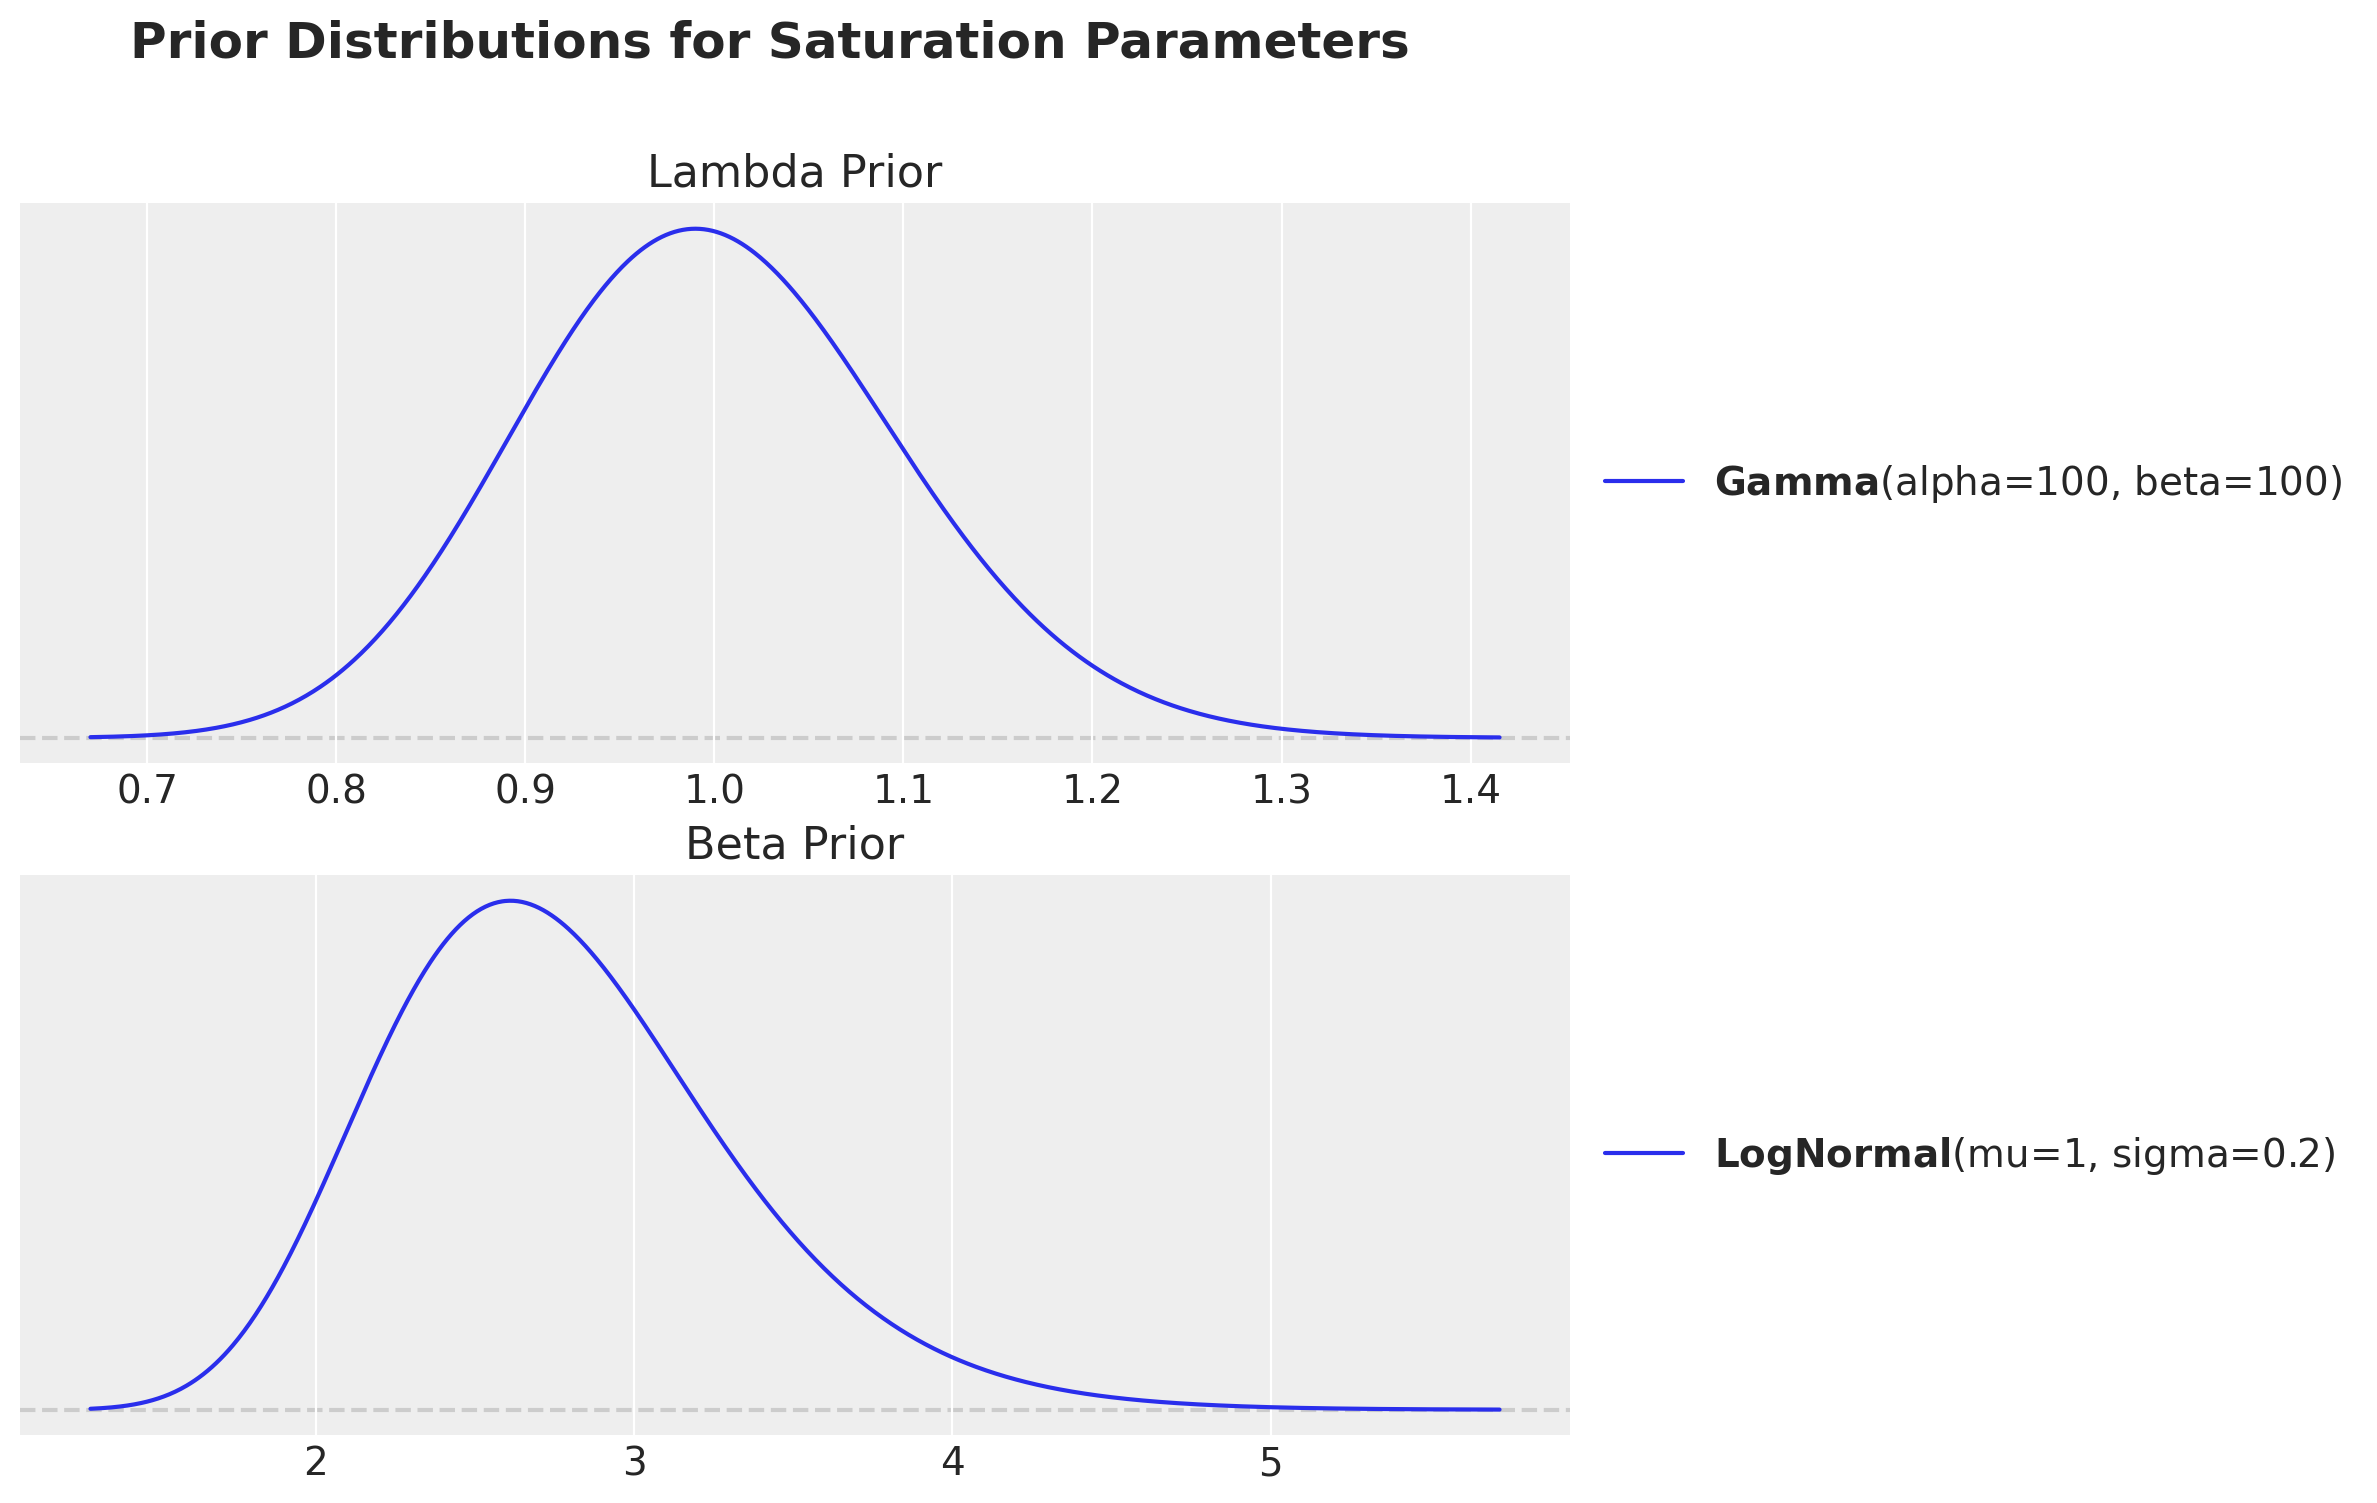

In [6]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(10, 8),
    sharex=False,
    sharey=False,
    layout="constrained",
)

pz.Gamma(alpha=100, beta=100).plot_pdf(ax=ax[0])
ax[0].set(title="Lambda Prior")

pz.LogNormal(mu=1, sigma=0.2).plot_pdf(ax=ax[1])
ax[1].set(title="Beta Prior")

fig.suptitle(
    "Prior Distributions for Saturation Parameters", fontsize=18, fontweight="bold"
);

Sampling: [saturation_beta, saturation_lam]
Sampling: []


Output()

/var/folders/cm/3dzy9rdd5s3672z0s1brjkvh0000gn/T/ipykernel_27633/4202441542.py:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


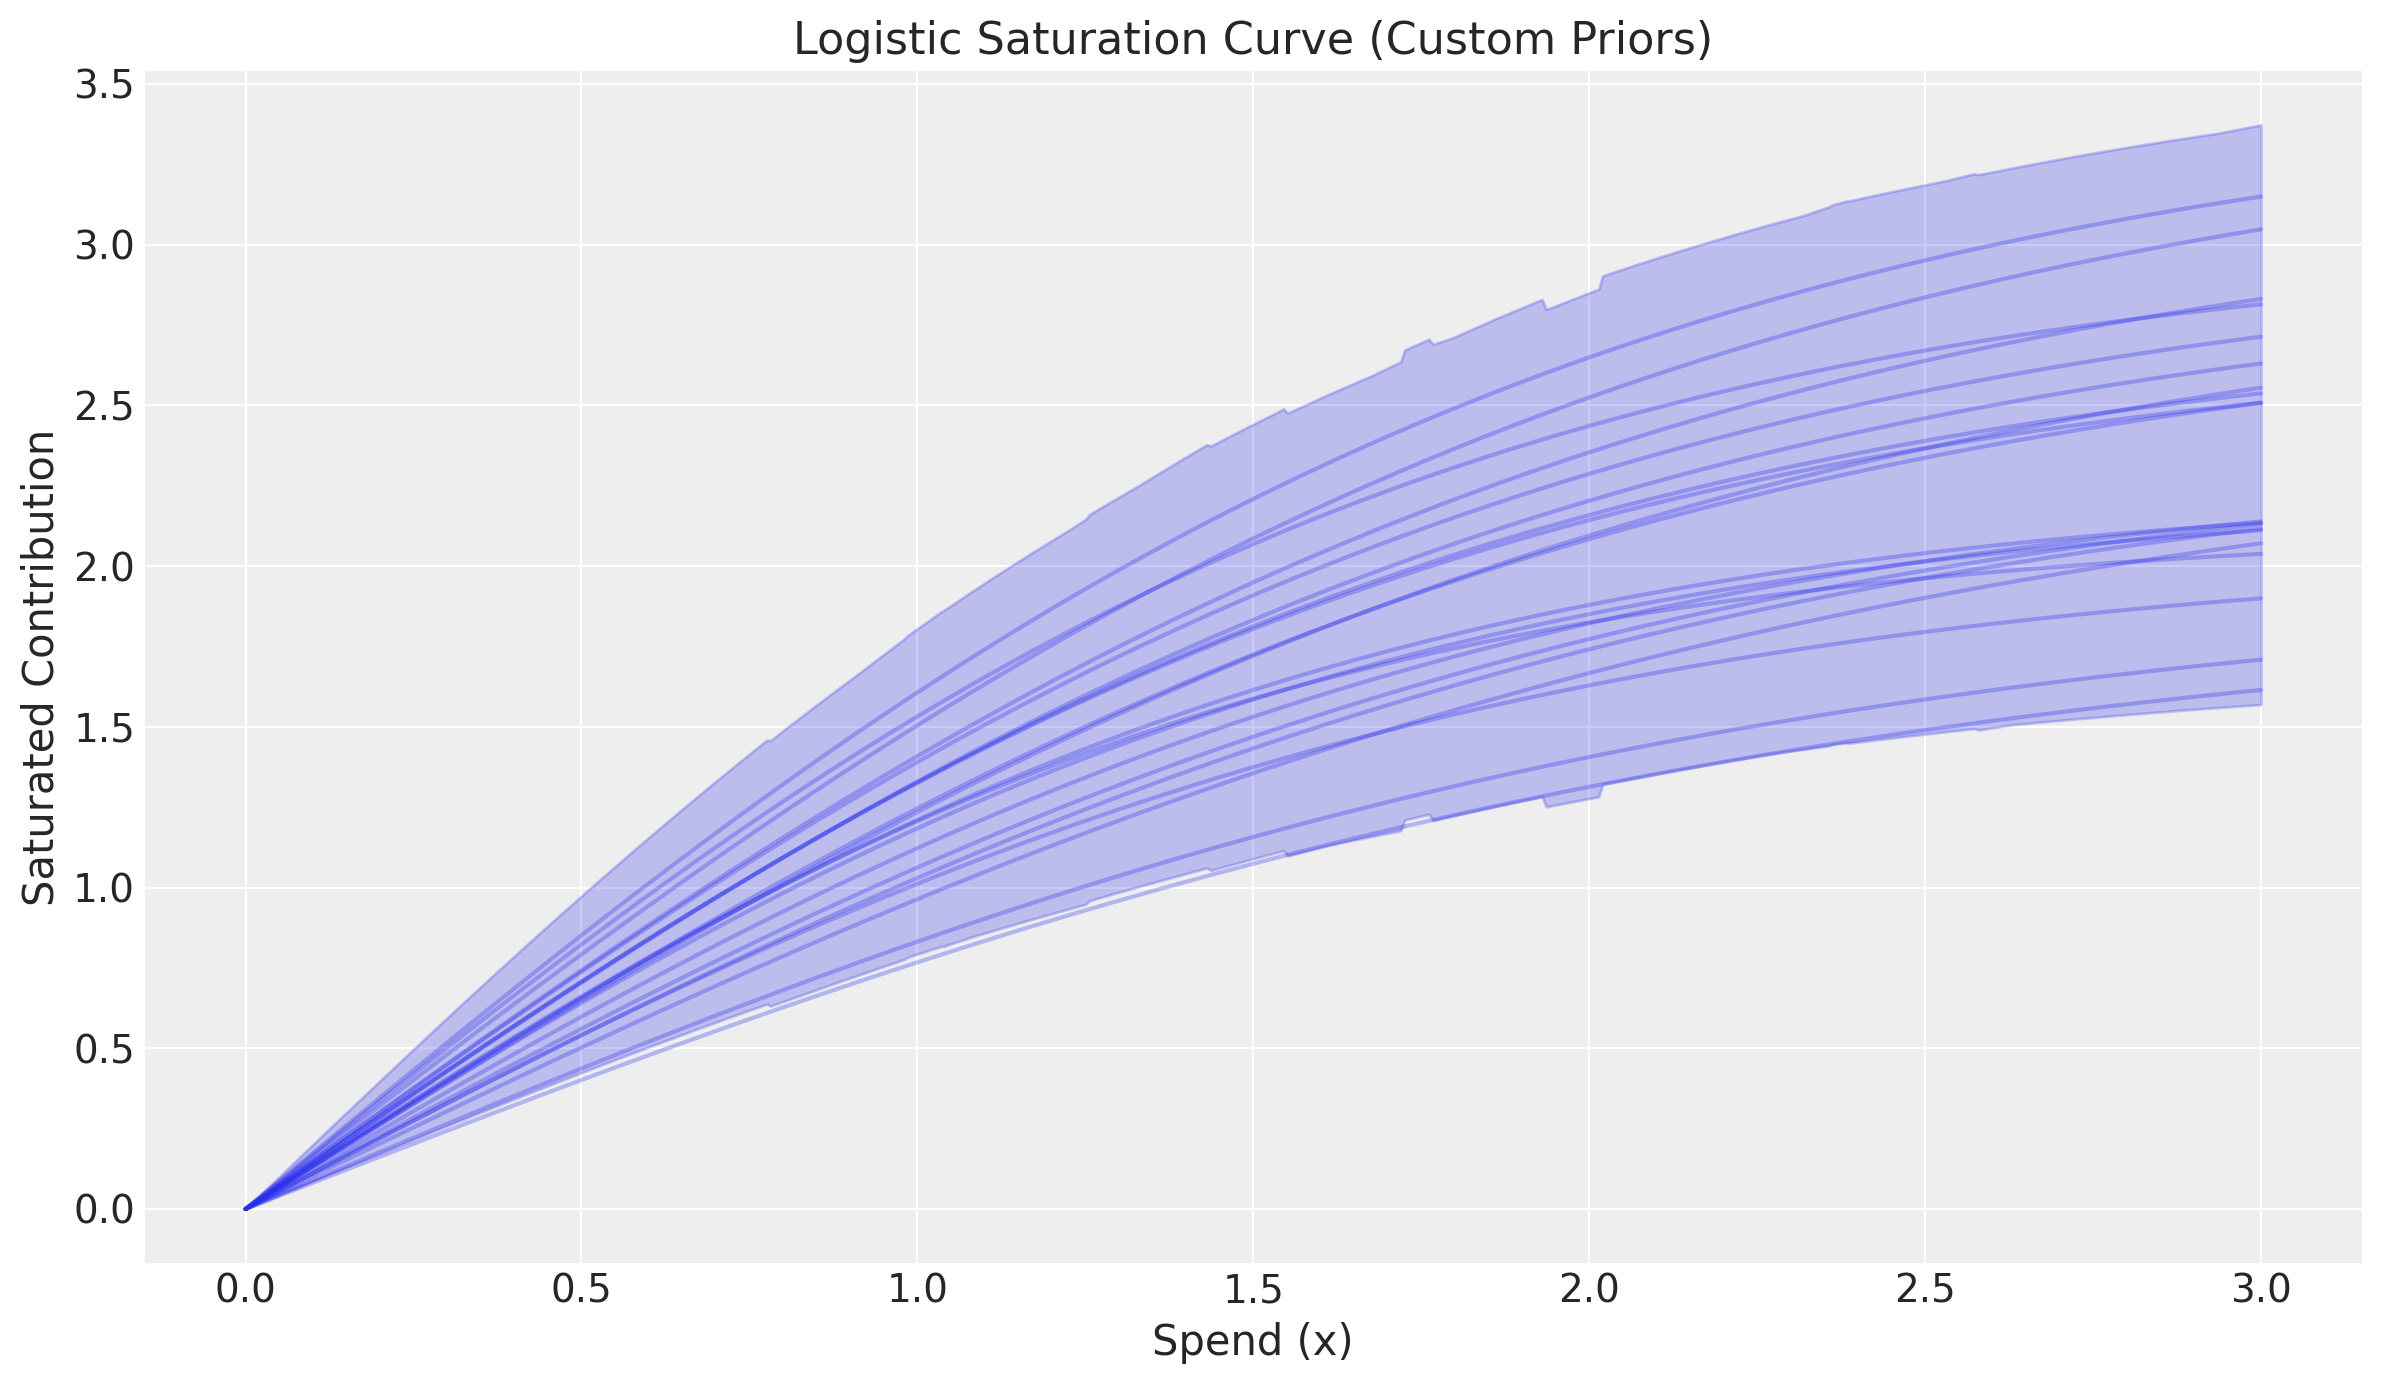

In [7]:
# Create a LogisticSaturation instance with default priors
saturation = LogisticSaturation(
    {
        "lam": Prior("Gamma", alpha=100, beta=100),
        "beta": Prior("LogNormal", mu=1, sigma=0.2),
    }
)

# Sample from the prior distributions
prior = saturation.sample_prior(random_seed=rng)

# Sample the saturation curve across a range of spend values
curve = saturation.sample_curve(prior, num_points=500, max_value=3)

# Plot the saturation curve with uncertainty (HDI and samples)
fig, axes = saturation.plot_curve(curve, n_samples=20, random_seed=rng)
axes[0].set(
    xlabel="Spend (x)",
    ylabel="Saturated Contribution",
    title="Logistic Saturation Curve (Custom Priors)",
)
plt.tight_layout()

We clearly see the samples are more concentrated around the mean.

We now see how these saturation curves are used in an MMM and how to extract business insights from them.

## Read Data

We use the same data as in the {ref}`mmm_multidimensional_example` tutorial.

In [8]:
data_path = data_dir / "mmm_multidimensional_example.csv"

data_df = pd.read_csv(data_path, parse_dates=["date"])
data_df.head(10)

,date,geo,x1,x2,event_1,event_2,y
0,2022-06-06,geo_a,5527.640078,0.000000,0,0,2647.596355
1,2022-06-06,geo_b,8849.257500,8063.918386,0,0,682.406280
2,2022-06-13,geo_a,6692.655692,0.000000,0,0,5020.823907
3,2022-06-13,geo_b,9073.817994,9354.014585,0,0,3753.104897
4,2022-06-20,geo_a,7124.016733,0.000000,0,0,6184.322132
5,2022-06-20,geo_b,7867.854558,5608.112521,0,0,3329.279953
6,2022-06-27,geo_a,7725.169902,0.000000,0,0,5446.374631
7,2022-06-27,geo_b,9712.332359,11760.981800,0,0,7544.192188
8,2022-07-04,geo_a,8545.792935,0.000000,0,0,10058.970814
9,2022-07-04,geo_b,6747.884370,6774.114961,0,0,2359.259385


Let's visualize the spend and sales data for each channel and geography.

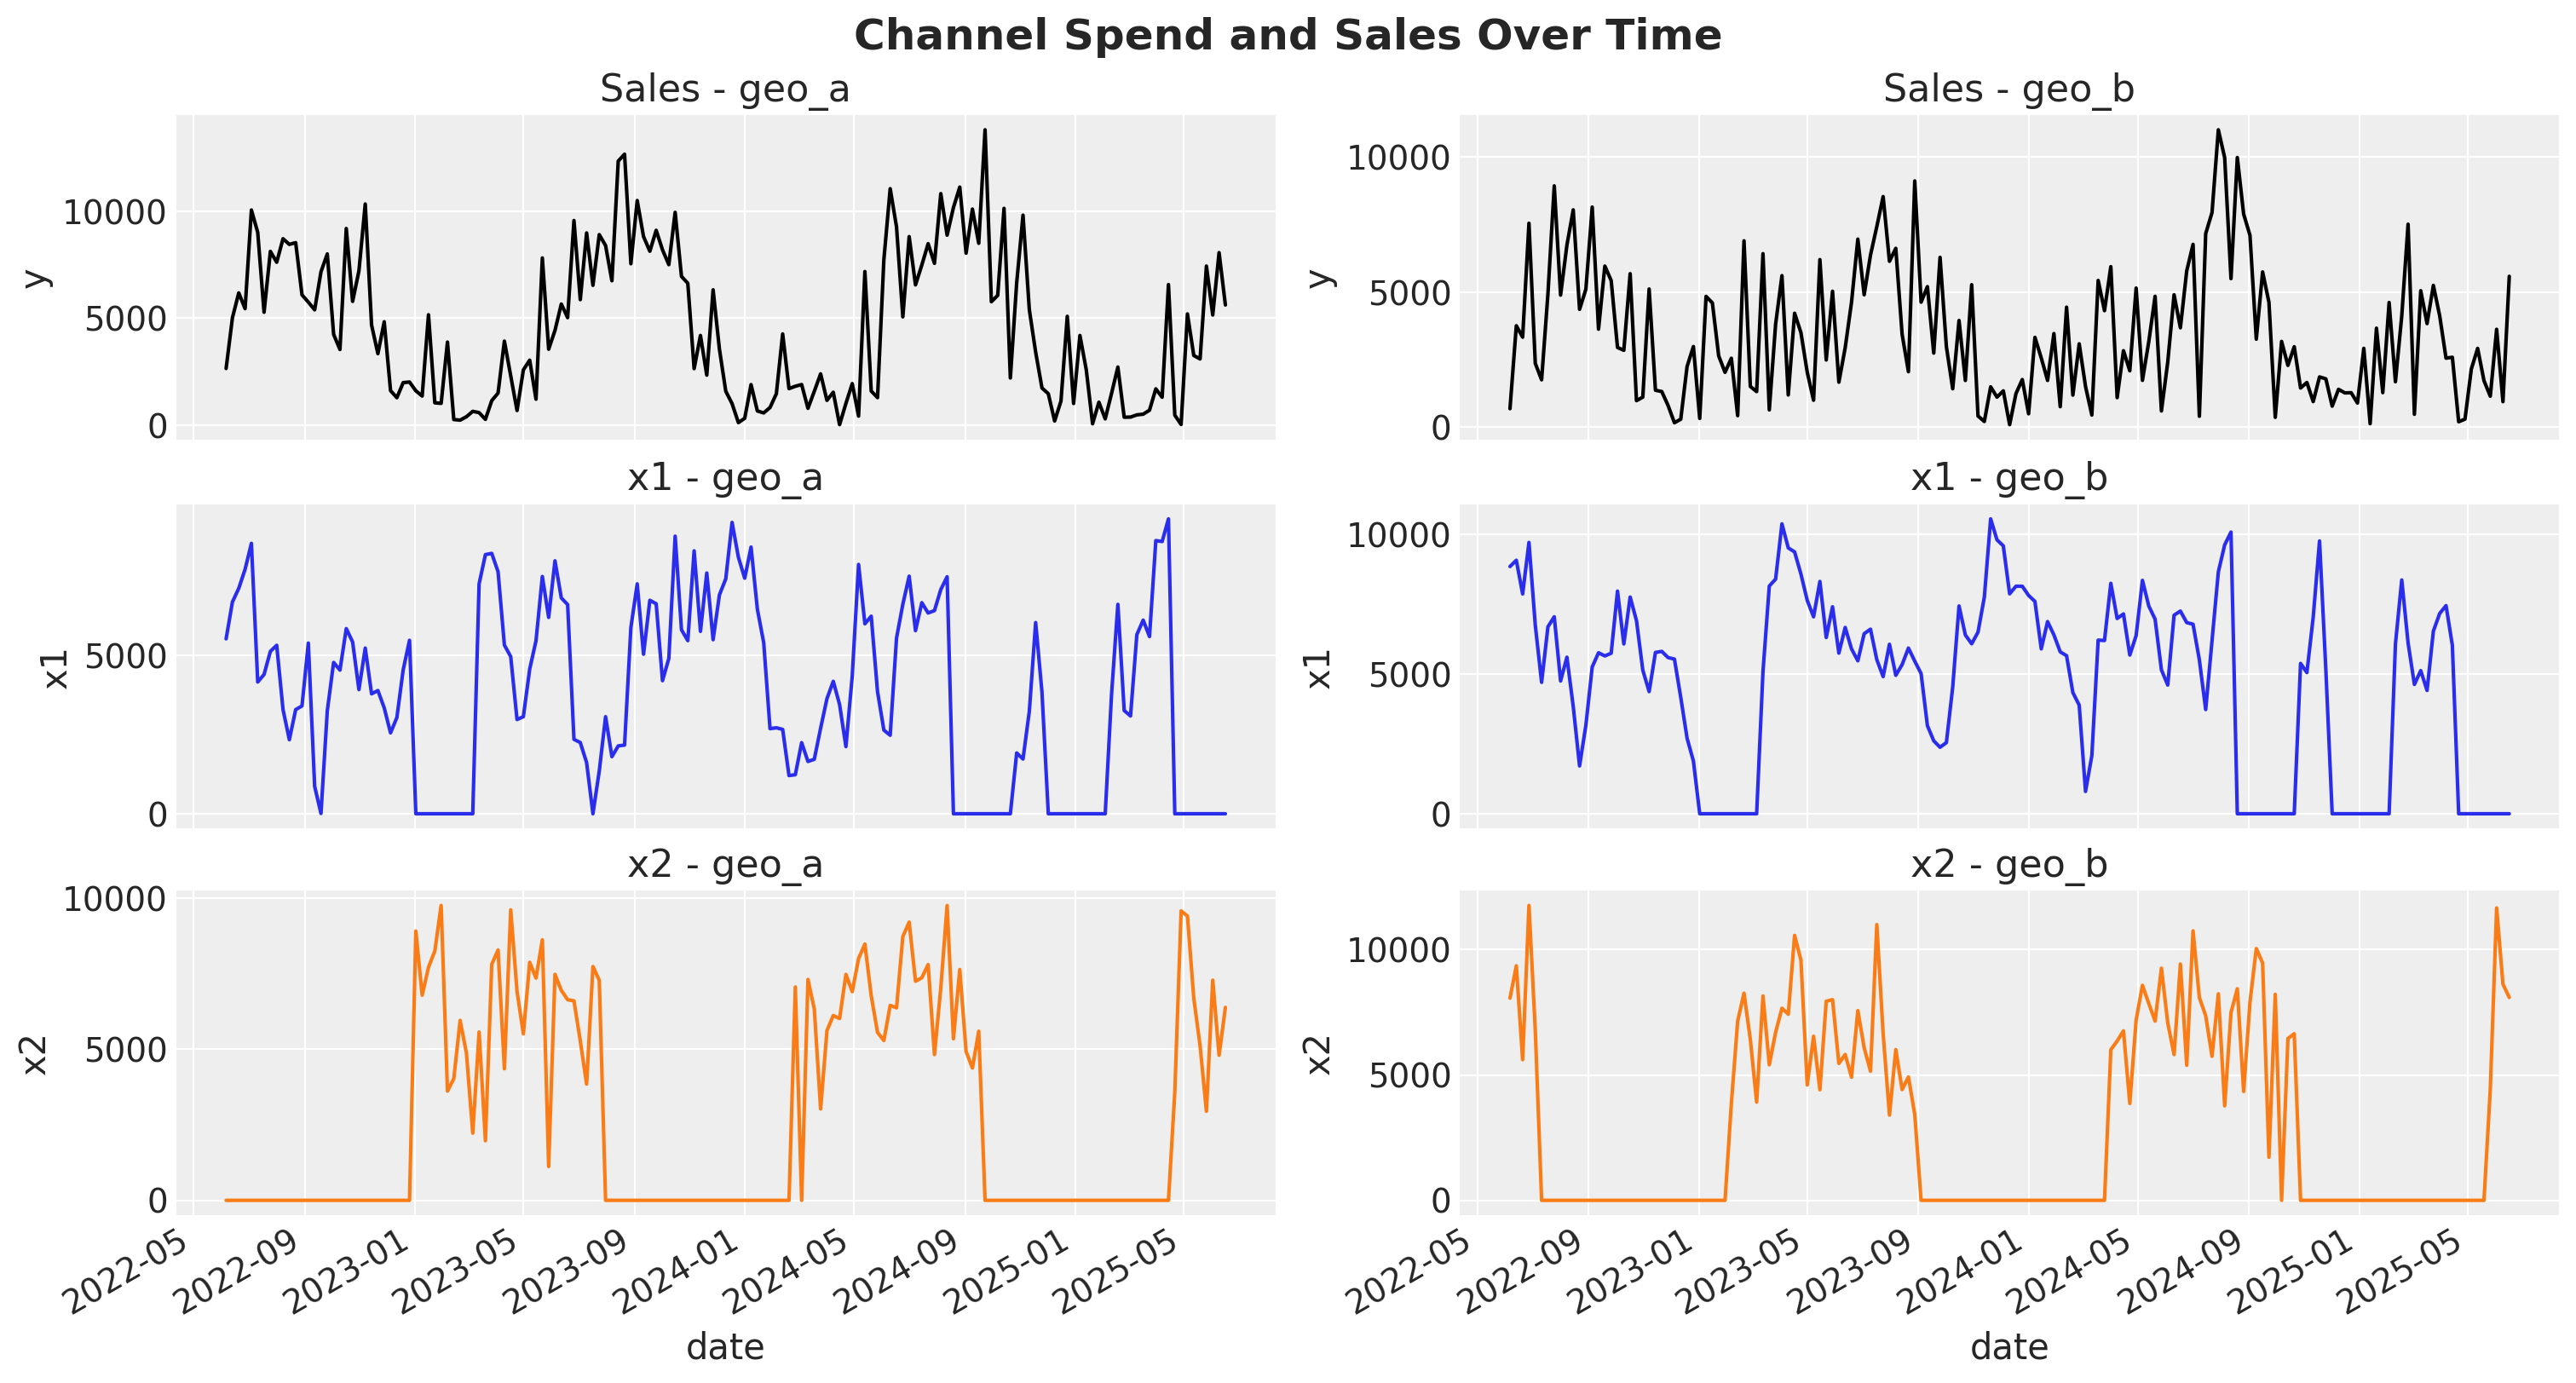

In [9]:
fig, axes = plt.subplots(
    nrows=3,
    ncols=2,
    figsize=(15, 8),
    sharex=True,
    sharey=False,
    layout="constrained",
)

for i, geo in enumerate(["geo_a", "geo_b"]):
    geo_data = data_df.query("geo == @geo")

    for j, channel in enumerate(["x1", "x2"]):
        sns.lineplot(
            x=geo_data["date"],
            y=geo_data[channel],
            color=f"C{j}",
            ax=axes[j + 1, i],
        )
        axes[j + 1, i].set_title(f"{channel} - {geo}")

    sns.lineplot(
        x=geo_data["date"],
        y=geo_data["y"],
        color="black",
        ax=axes[0, i],
    )
    axes[0, i].set_title(f"Sales - {geo}")

fig.autofmt_xdate()
fig.suptitle("Channel Spend and Sales Over Time", fontsize=18, fontweight="bold");

## Model Specification and Fitting

We'll fit a multi-dimensional MMM with:
- **Geometric Adstock**: Models the carry-over effect of advertising
- **Logistic Saturation**: Models diminishing returns as spend increases

For simplicity, we use a streamlined model configuration.

In [10]:
# Define adstock and saturation transformations
adstock = GeometricAdstock(
    priors={"alpha": Prior("Beta", alpha=2, beta=5, dims=("geo", "channel"))},
    l_max=8,
)

saturation = LogisticSaturation(
    priors={
        "beta": Prior("Gamma", mu=0.3, sigma=0.15, dims=("geo", "channel")),
        "lam": Prior("Gamma", mu=0.5, sigma=0.25, dims="channel"),
    }
)

# Model configuration
model_config = {
    "intercept": Prior("Gamma", mu=0.5, sigma=0.25, dims="geo"),
    "gamma_control": Prior("Normal", mu=0, sigma=0.5, dims="control"),
    "likelihood": Prior(
        "TruncatedNormal",
        lower=0,
        sigma=Prior("HalfNormal", sigma=1.5),
        dims=("date", "geo"),
    ),
}

# Create the MMM instance
mmm = MMM(
    date_column="date",
    target_column="y",
    channel_columns=["x1", "x2"],
    control_columns=["event_1", "event_2"],
    dims=("geo",),
    scaling={
        "channel": {"method": "max", "dims": ()},
        "target": {"method": "max", "dims": ()},
    },
    adstock=adstock,
    saturation=saturation,
    yearly_seasonality=2,
    model_config=model_config,
)

Now we fit the model.

In [11]:
# Prepare training data
x_train = data_df.drop(columns=["y"])
y_train = data_df["y"]

# Build and fit the model
mmm.build_model(X=x_train, y=y_train)

# Add original scale contribution variables (needed for original_scale=True in plots)
mmm.add_original_scale_contribution_variable(var=["channel_contribution", "y"])

sample_kwargs = {
    "draws": 1_500,
    "tune": 1_000,
    "chains": 4,
    "target_accept": 0.95,
    "nuts_sampler": "nutpie",
    "random_seed": rng,
}

# Fit the model
mmm.fit(
    X=x_train,
    y=y_train,
    **sample_kwargs,
)

# Sample posterior predictive
_ = mmm.sample_posterior_predictive(X=x_train, random_seed=rng)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2500,0,0.28,15
,2500,0,0.28,15
,2500,0,0.29,15
,2500,0,0.29,15


Output()

Sampling: [y]


Output()

In [12]:
# Quick check of model diagnostics
print(f"Divergences: {mmm.idata.sample_stats.diverging.sum().values}")

Divergences: 0


## Visualization 1: Direct/Marginal Contribution 

The `saturation_scatterplot` shows the **direct relationship between spend and contribution at each time point**. This visualization answers the question:

> *"Given a specific spend level, what is the direct contribution to sales?"*

Each point in this plot represents a single observation (one time period), showing:
- **X-axis**: Channel spend at that time point
- **Y-axis**: Direct contribution to sales at that time point

/var/folders/cm/3dzy9rdd5s3672z0s1brjkvh0000gn/T/ipykernel_27633/1864980976.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


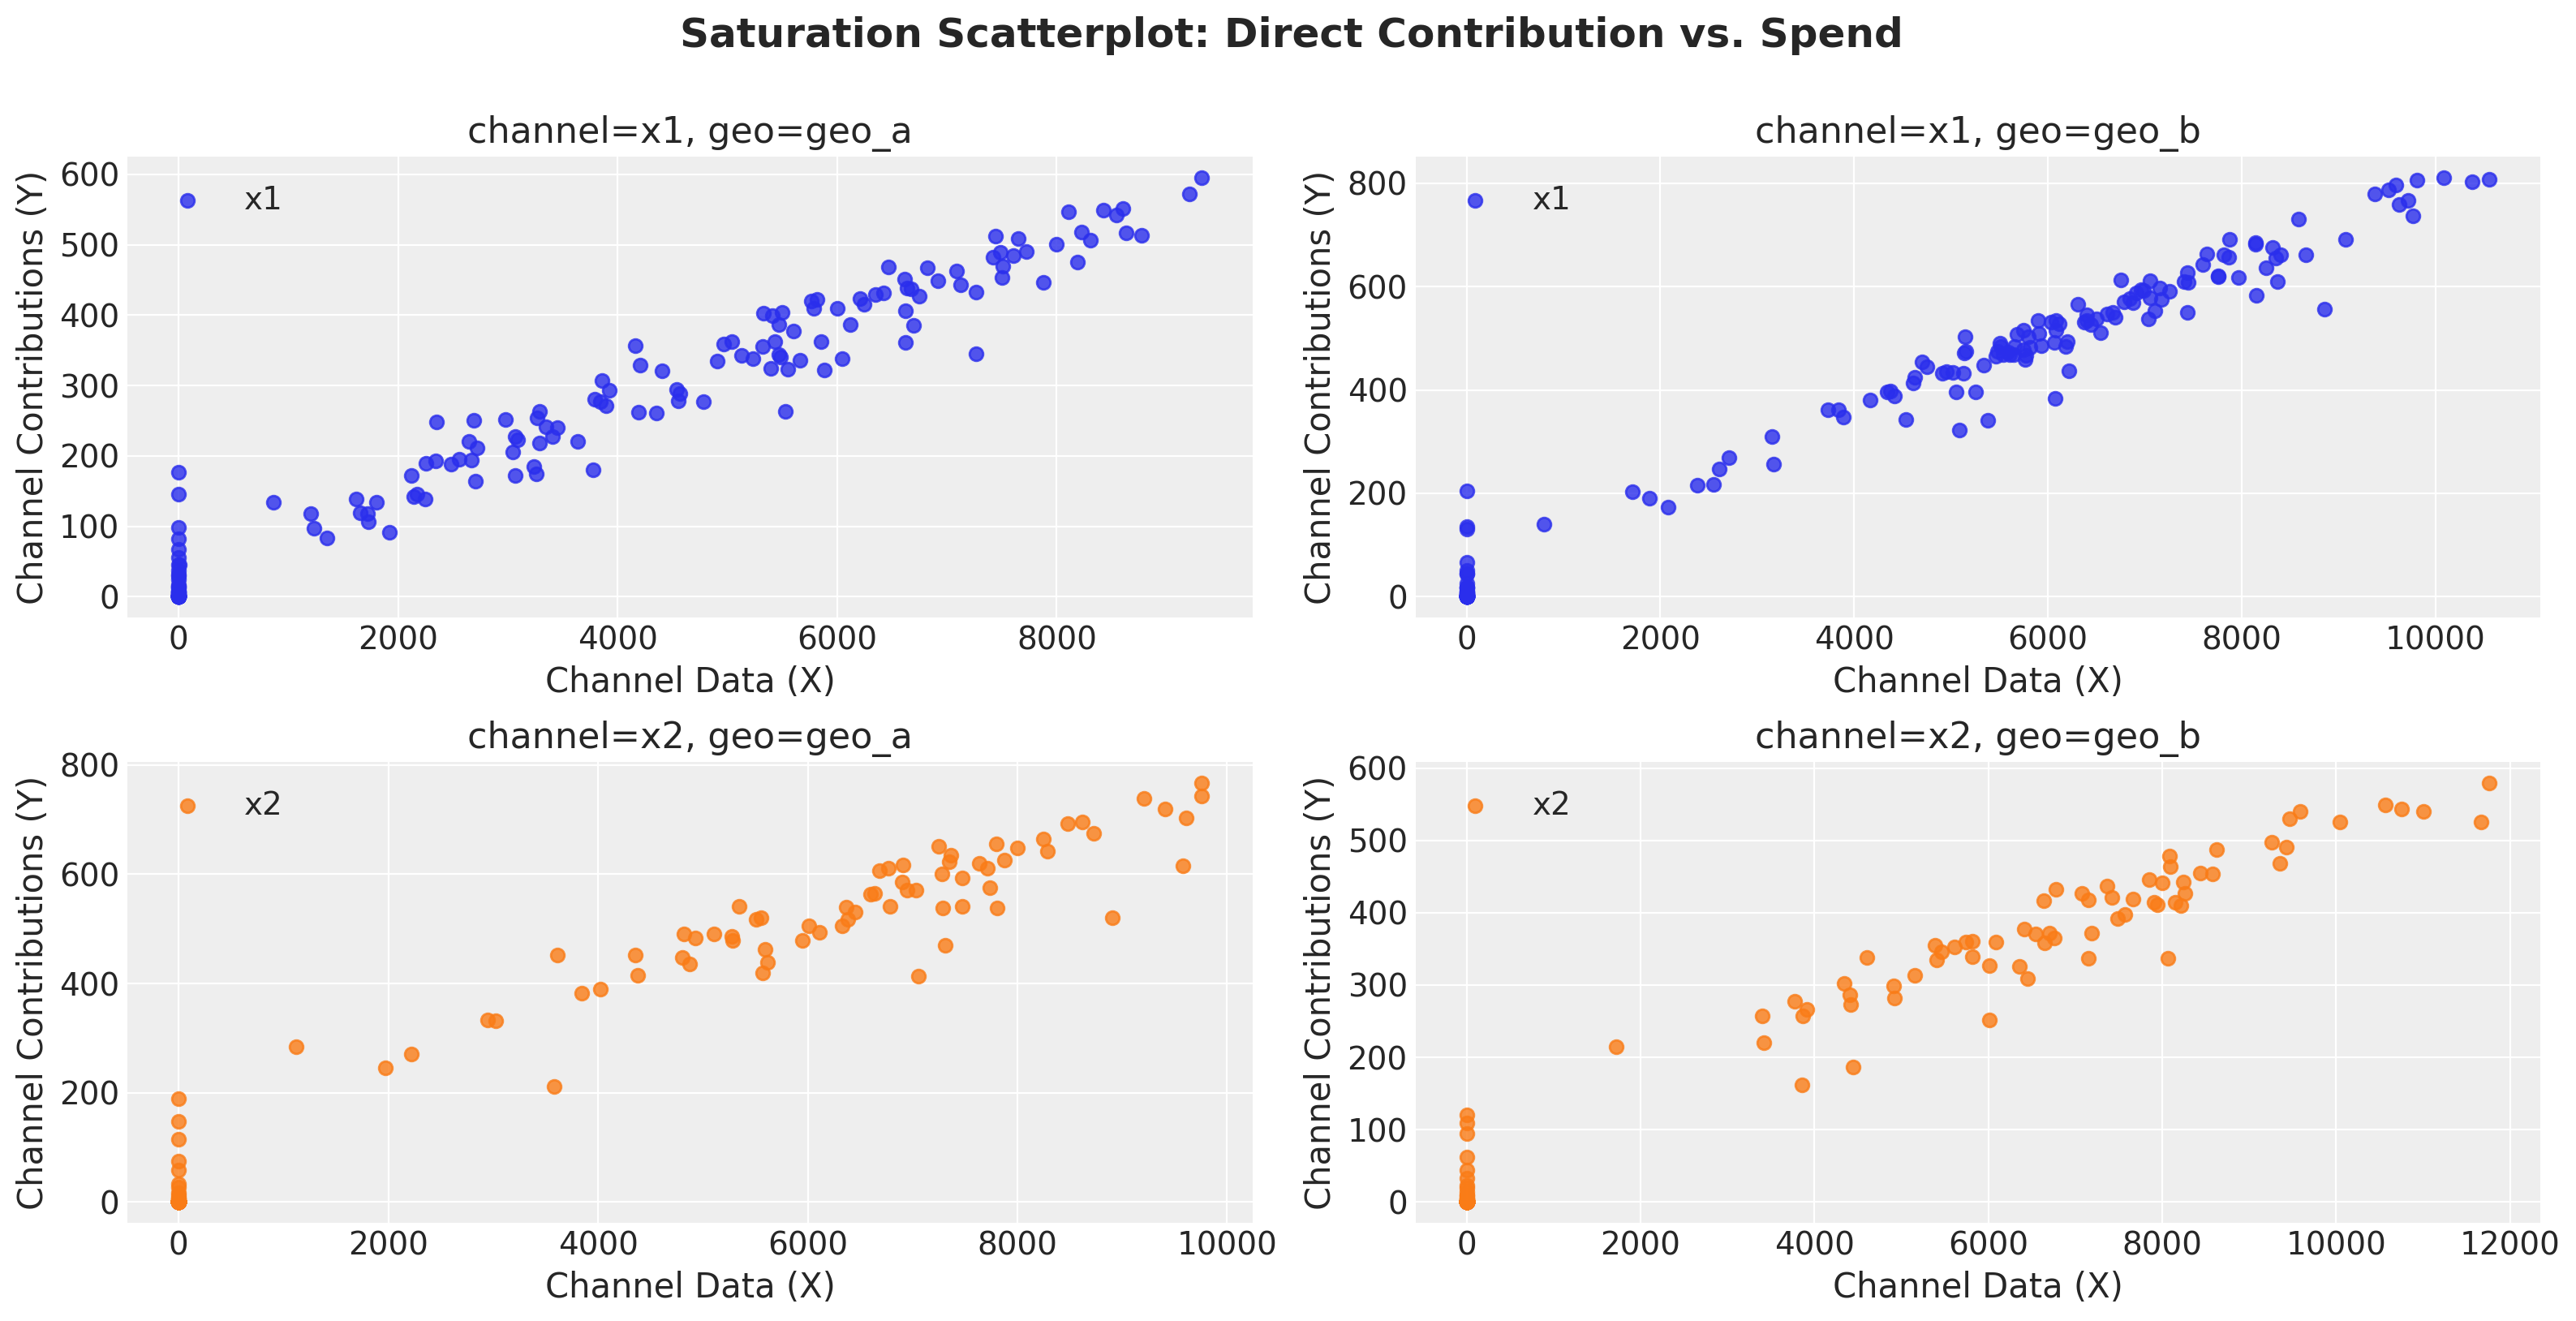

In [13]:
fig, axes = mmm.plot.saturation_scatterplot(
    width_per_col=8,
    height_per_row=4,
    original_scale=True,
)
fig.suptitle(
    "Saturation Scatterplot: Direct Contribution vs. Spend",
    fontsize=18,
    fontweight="bold",
    y=1.01,
)
plt.tight_layout()

**How to interpret this plot:**

1. **Shape of the curve**: The fitted line shows how contribution increases with spend, with diminishing returns visible as the curve flattens at higher spend levels.

2. **Scatter points**: Each point represents a specific date's spend-contribution pair. 

```{note}
This plot shows the **instantaneous/marginal** relationship. It tells you "if I spend X on a given day, I expect Y contribution on that day."

The reason you see non-zero contribution even at zero spend is because of the adstock effect.
```

## Visualization 2: Total Contribution over Spend Share 

The `plot_channel_contribution_grid` shows how **total contribution (summed over all time periods)** changes as you scale overall spend. This visualization answers the question:

> *"If I increase/decrease my total budget by X%, what is the total impact on sales?"*

This is a **counterfactual analysis**: we ask "what would have happened if we had spent more or less?"

Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
/Users/juanitorduz/Documents/pymc-marketing/pymc_marketing/mmm/plot.py:1966: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


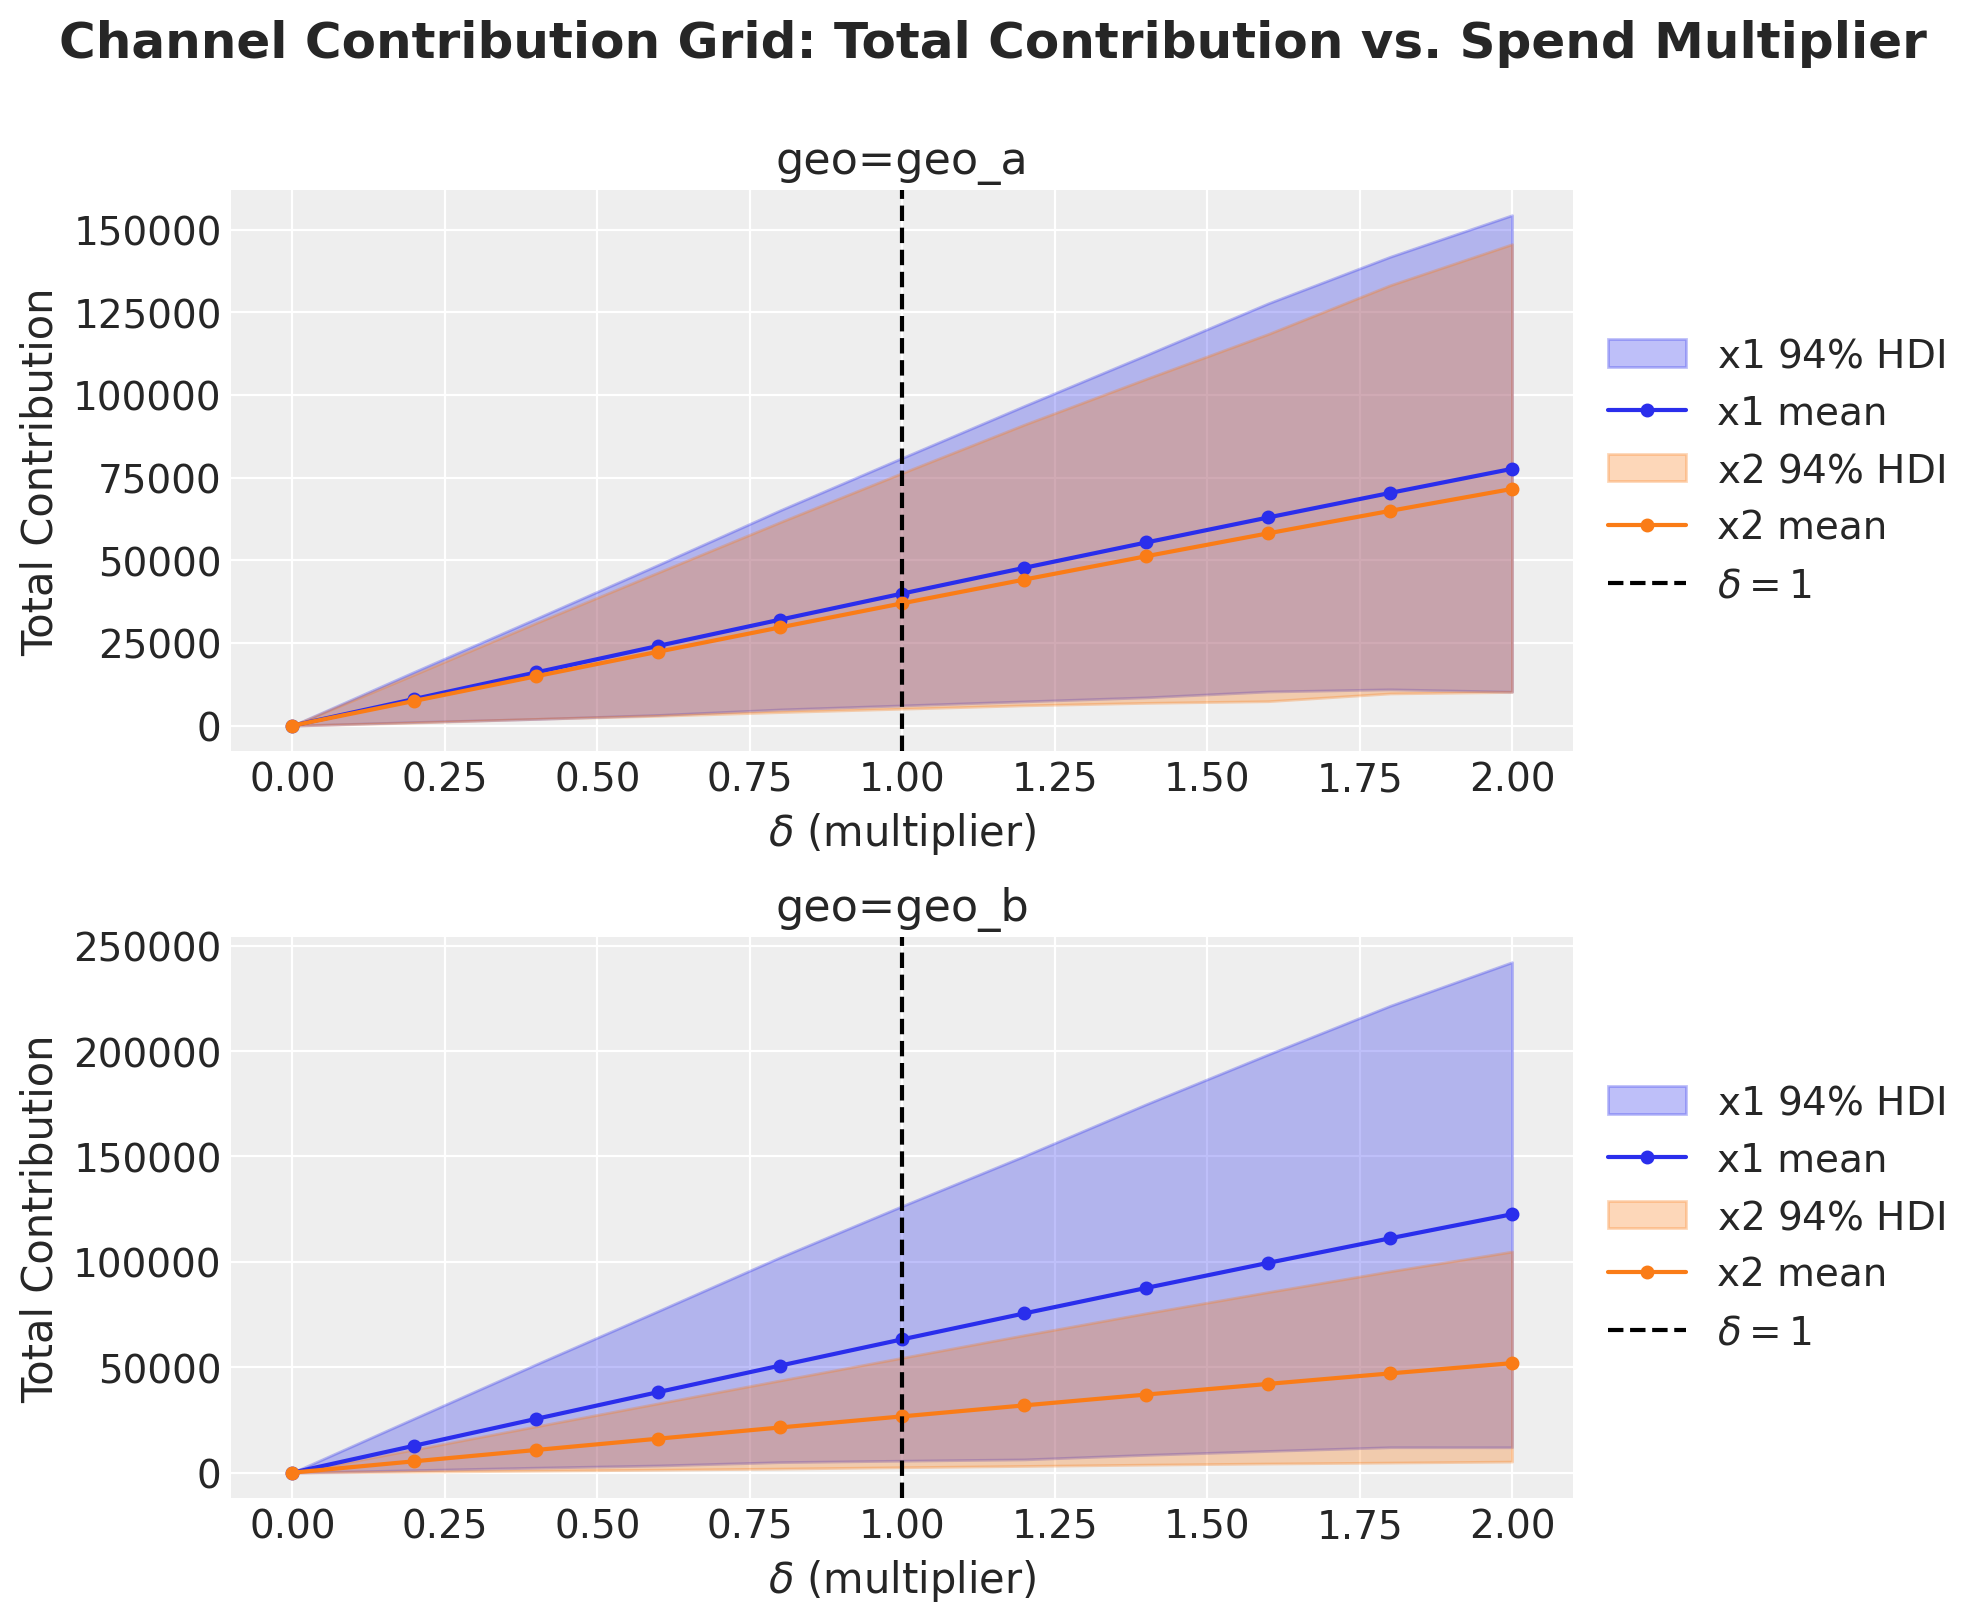

In [14]:
fig, axes = mmm.plot_channel_contribution_grid(
    start=0.0,
    stop=2.0,
    num=11,
    hdi_prob=0.94,
)
fig.suptitle(
    "Channel Contribution Grid: Total Contribution vs. Spend Multiplier",
    fontsize=18,
    fontweight="bold",
    y=1.01,
)
plt.tight_layout()

**How to interpret this plot:**

1. **X-axis (δ - delta)**: The spend multiplier. A value of 1.0 represents the actual historical spend, 0.5 means half the spend, and 2.0 means double the spend.

2. **Y-axis (Total Contribution)**: The sum of contributions across all time periods in the dataset.

3. **Vertical line at δ=1**: This marks the current/historical spend level.

4. **HDI bands**: Show the uncertainty in total contribution at each spend level.

5. **Curve shape**: 
   - Steep slope at low δ → High marginal returns (you're not yet saturated)
   - Flattening slope at high δ → Diminishing returns (approaching saturation)

```{important}
This plot shows the **global/total** relationship. It tells you "across the entire time period, if I had scaled all my spend by factor δ, my total contribution would be Y."
```

## Advanced Usage 

The `plot_channel_contribution_grid` method supports several advanced options for customization.

### Using Absolute X-Range

Instead of showing the multiplier, you can display absolute spend values on the x-axis using `absolute_xrange=True`:

Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
/Users/juanitorduz/Documents/pymc-marketing/pymc_marketing/mmm/plot.py:1966: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


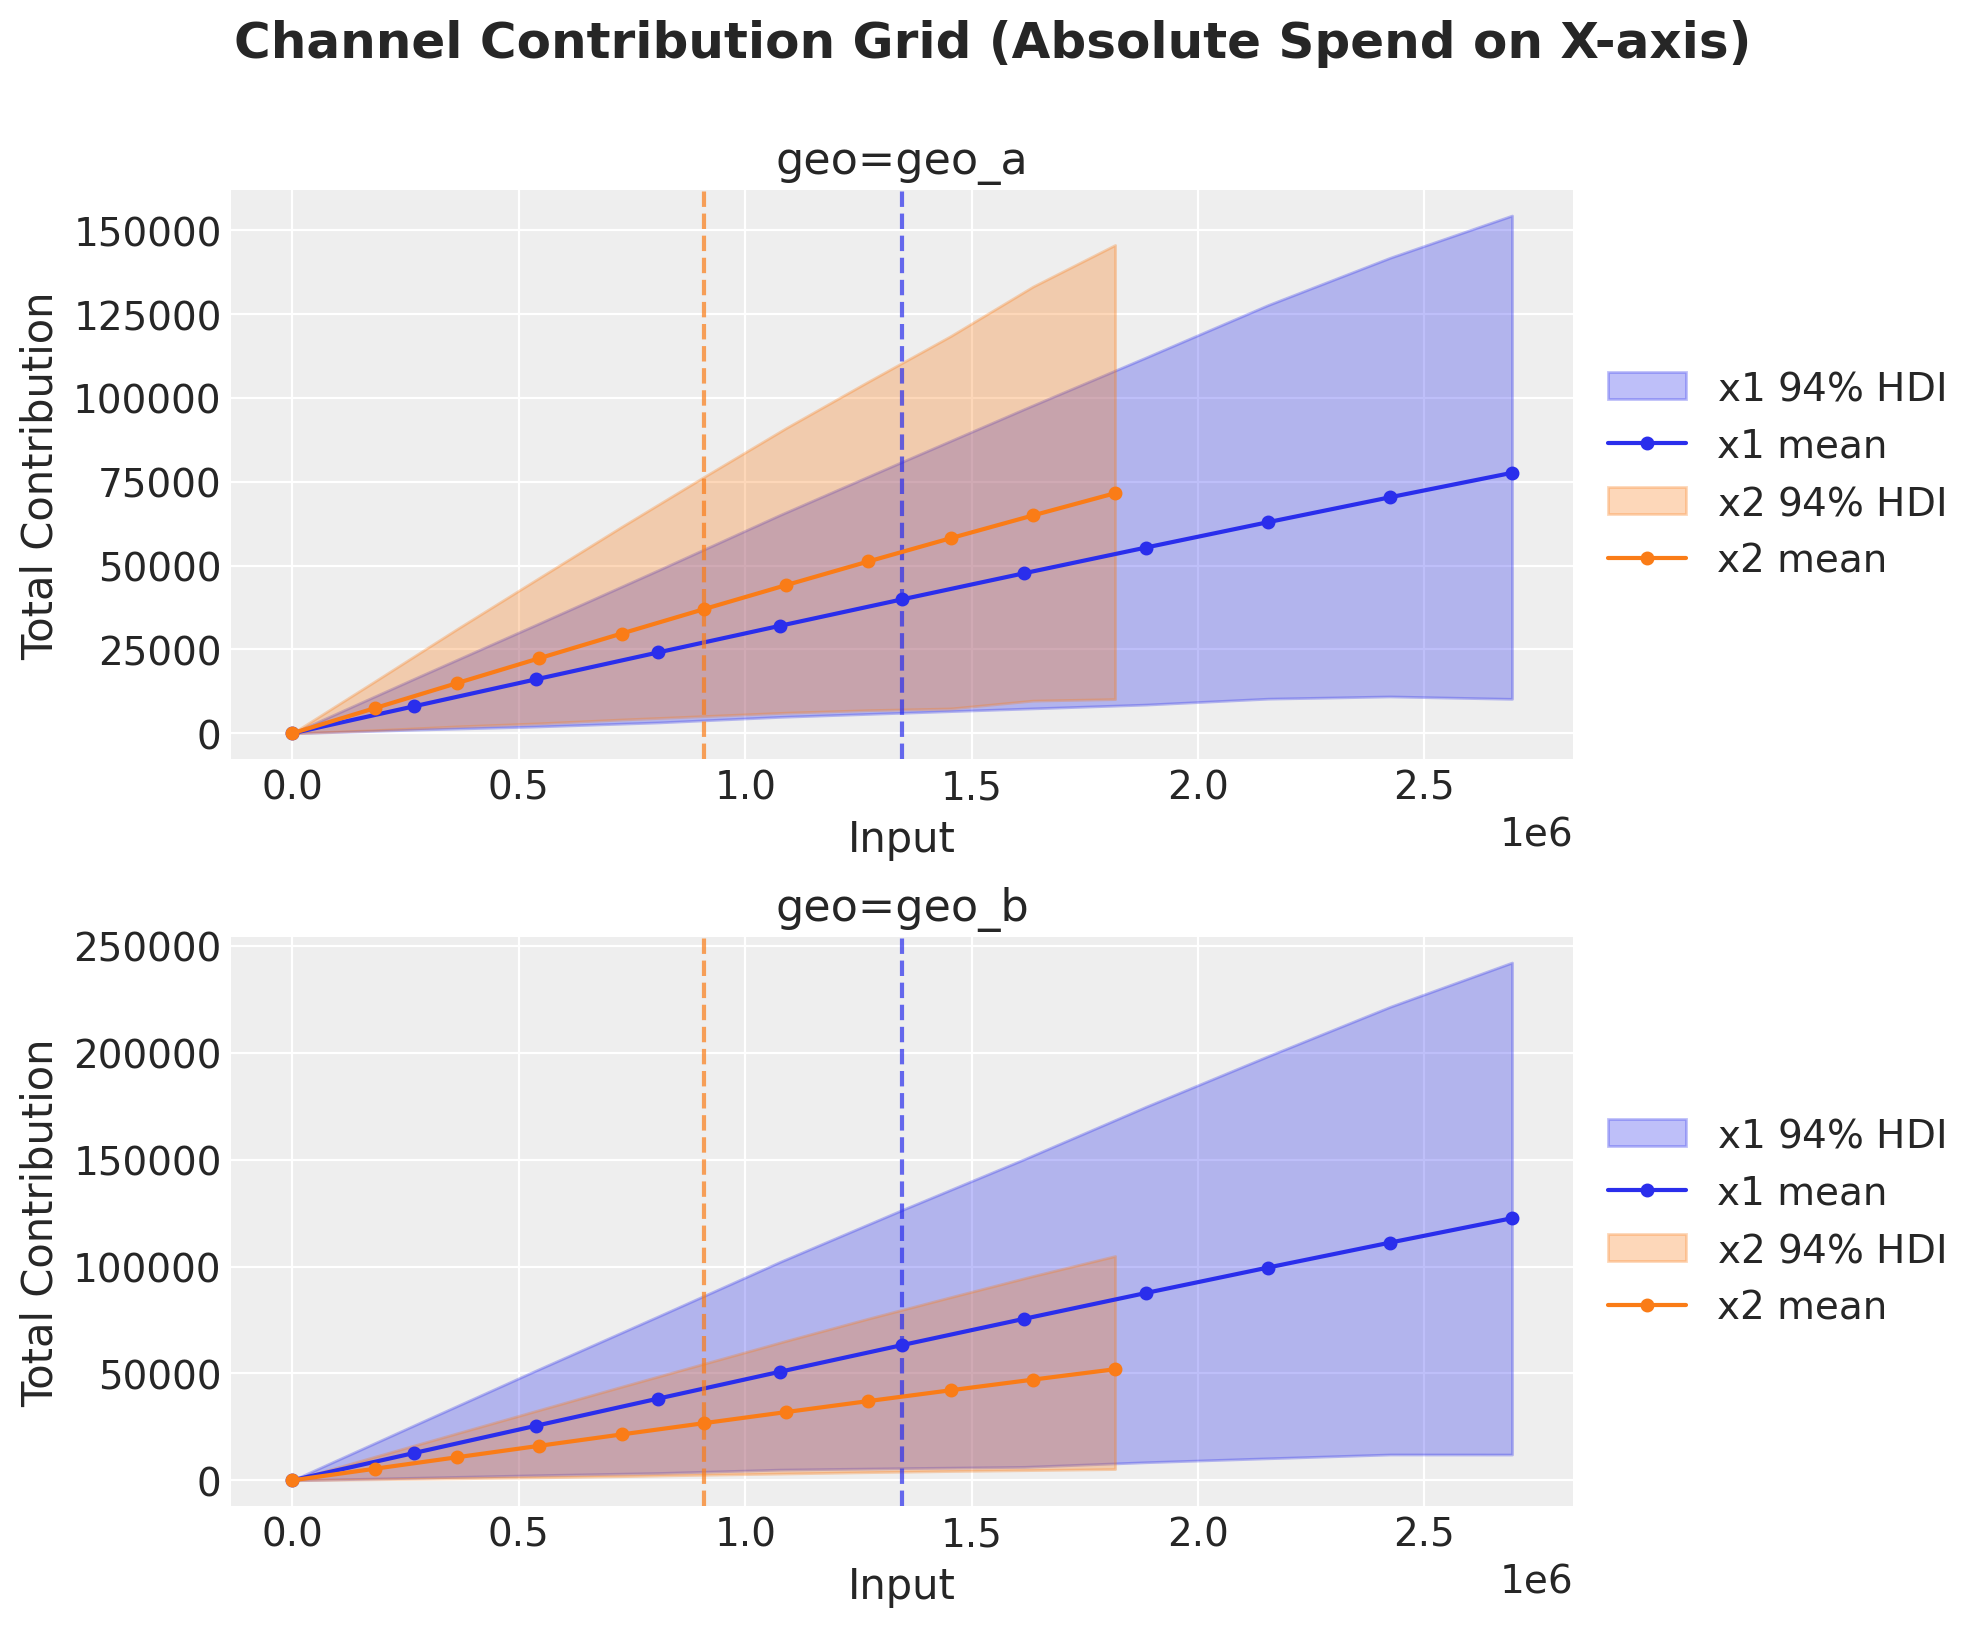

In [15]:
fig, axes = mmm.plot_channel_contribution_grid(
    start=0.0,
    stop=2.0,
    num=11,
    absolute_xrange=True,  # Show absolute spend on x-axis
    hdi_prob=0.94,
)
fig.suptitle(
    "Channel Contribution Grid (Absolute Spend on X-axis)",
    fontsize=18,
    fontweight="bold",
    y=1.01,
)
plt.tight_layout()

With `absolute_xrange=True`:
- The x-axis shows actual spend values (total spend across all dates)
- Vertical dashed lines indicate the current total spend for each channel
- This view is more intuitive for budget discussions ("If we spend X total, we get Y contribution")

### Filtering by Geography

Use the `dims` parameter to focus on specific geographies:

Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
/Users/juanitorduz/Documents/pymc-marketing/pymc_marketing/mmm/plot.py:1966: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


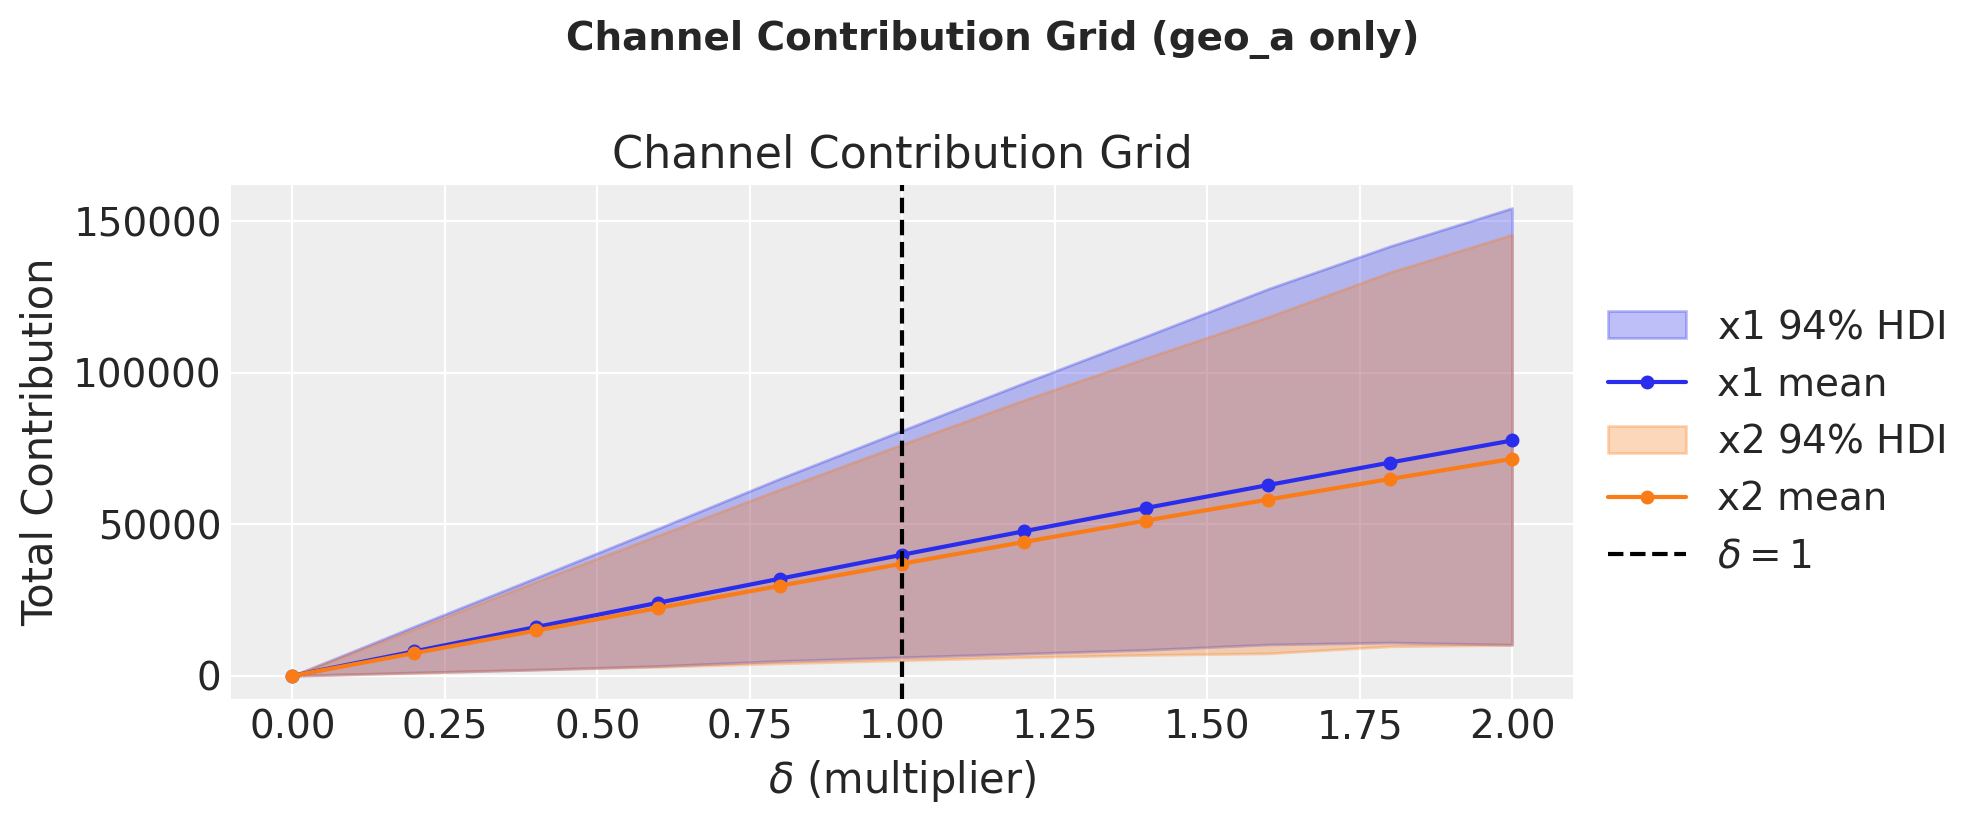

In [16]:
# Filter to show only geo_a
fig, axes = mmm.plot_channel_contribution_grid(
    start=0.0,
    stop=2.0,
    num=11,
    dims={"geo": "geo_a"},  # Filter to single geography
    hdi_prob=0.94,
)
fig.suptitle(
    "Channel Contribution Grid (geo_a only)", fontsize=14, fontweight="bold", y=1.02
)
plt.tight_layout()

### Aggregating Across Geographies

Use the `aggregation` parameter to combine results across dimensions. This is useful when you want to see the total impact across all markets:

Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
/Users/juanitorduz/Documents/pymc-marketing/pymc_marketing/mmm/plot.py:1966: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


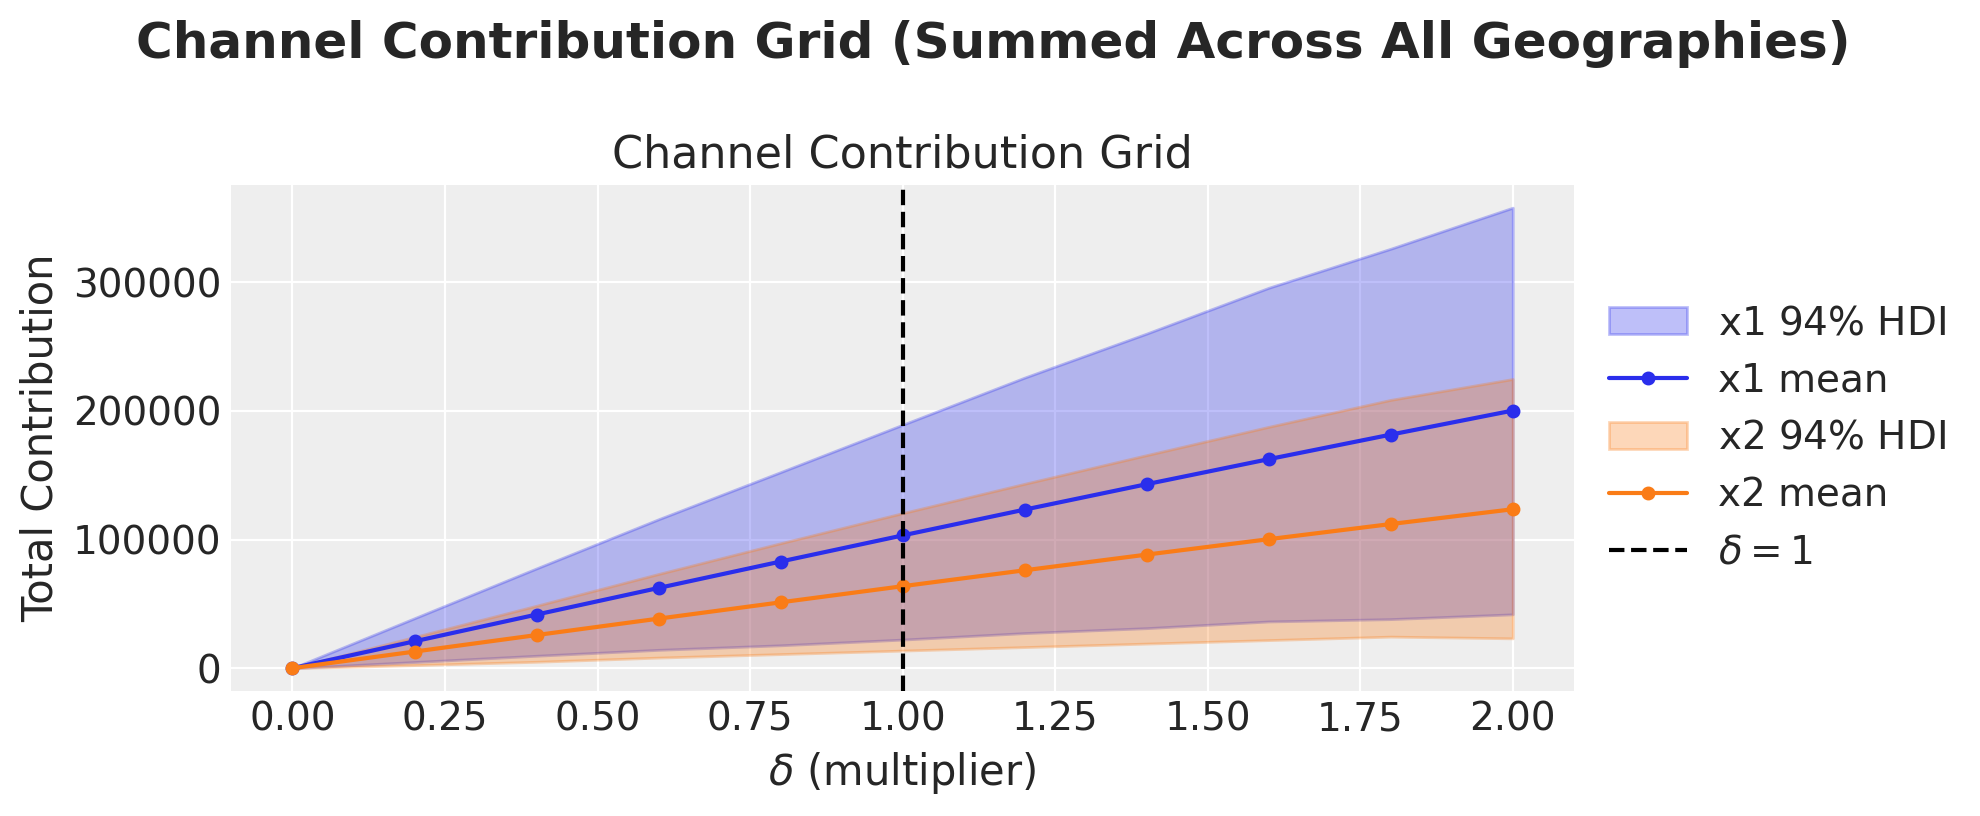

In [17]:
# Aggregate (sum) contributions across all geographies
fig, axes = mmm.plot_channel_contribution_grid(
    start=0.0,
    stop=2.0,
    num=11,
    aggregation={"sum": ("geo",)},  # Sum over geo dimension
    hdi_prob=0.94,
)
fig.suptitle(
    "Channel Contribution Grid (Summed Across All Geographies)",
    fontsize=18,
    fontweight="bold",
    y=1.01,
)
plt.tight_layout()

Supported aggregation operations:
- `"sum"`: Sum contributions across the specified dimensions
- `"mean"`: Average contributions across the specified dimensions
- `"median"`: Median contributions across the specified dimensions

## Summary

In this tutorial, we explored two complementary ways to visualize media saturation in Marketing Mix Models:

1. **`saturation_scatterplot`**: Shows the direct/marginal relationship between spend and contribution at each time point. Best for understanding the shape of saturation and validating model behavior.

2. **`plot_channel_contribution_grid`**: Shows how total contribution changes as you scale overall spend. Best for budget planning, what-if analysis, and making allocation decisions.

Understanding the difference between these visualizations is crucial for correctly interpreting your MMM results and making informed marketing decisions.

In [18]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pymc,pytensor

Last updated: Thu, 15 Jan 2026

Python implementation: CPython
Python version       : 3.13.11
IPython version      : 9.9.0

pymc    : 5.27.0
pytensor: 2.36.3

arviz         : 0.23.0
matplotlib    : 3.10.8
numpy         : 2.3.5
pandas        : 2.3.3
preliz        : 0.23.0
pymc_extras   : 0.7.0
pymc_marketing: 0.17.1
seaborn       : 0.13.2

Watermark: 2.6.0

